Using temporary directory: C:\Users\Yatin\AppData\Local\Temp\tmpjpuq5rcf
Extracting C:\Users\Yatin\Downloads\mit-bih-noise-stress-test-database-1.0.0.zip...
Extracted to C:\Users\Yatin\AppData\Local\Temp\tmpjpuq5rcf\MIT-BIH Noise Stress Test

DATASET: MIT-BIH NOISE STRESS TEST
TARGET RECORD: 101

Available records in MIT-BIH Noise Stress Test:
Found 30 records: ['118_02', '118_04', '118_06', '118_08', '118_10', '118_12', '118e00', '118e06', '118e12', '118e18', '118e24', '118e_6', '119_02', '119_04', '119_06', '119_08', '119_10', '119_12', '119e00', '119e06', '119e12', '119e18', '119e24', '119e_6', 'bw', 'em', 'ma', 'oldbw', 'oldem', 'oldma']

Record 101 not found in MIT-BIH Noise Stress Test!
Using first available record: 118_02

Files for record 118_02:
  .dat: 118_02.dat
  .hea: 118_02.hea

--- COMPREHENSIVE RECORD INFORMATION ---
Record Name: 118_02
Sampling Frequency: 360 Hz
Number of Samples: 650,000
Duration: 1805.56 seconds (30.1 minutes)
Number of Signals: 2
Signal Names: ['rec

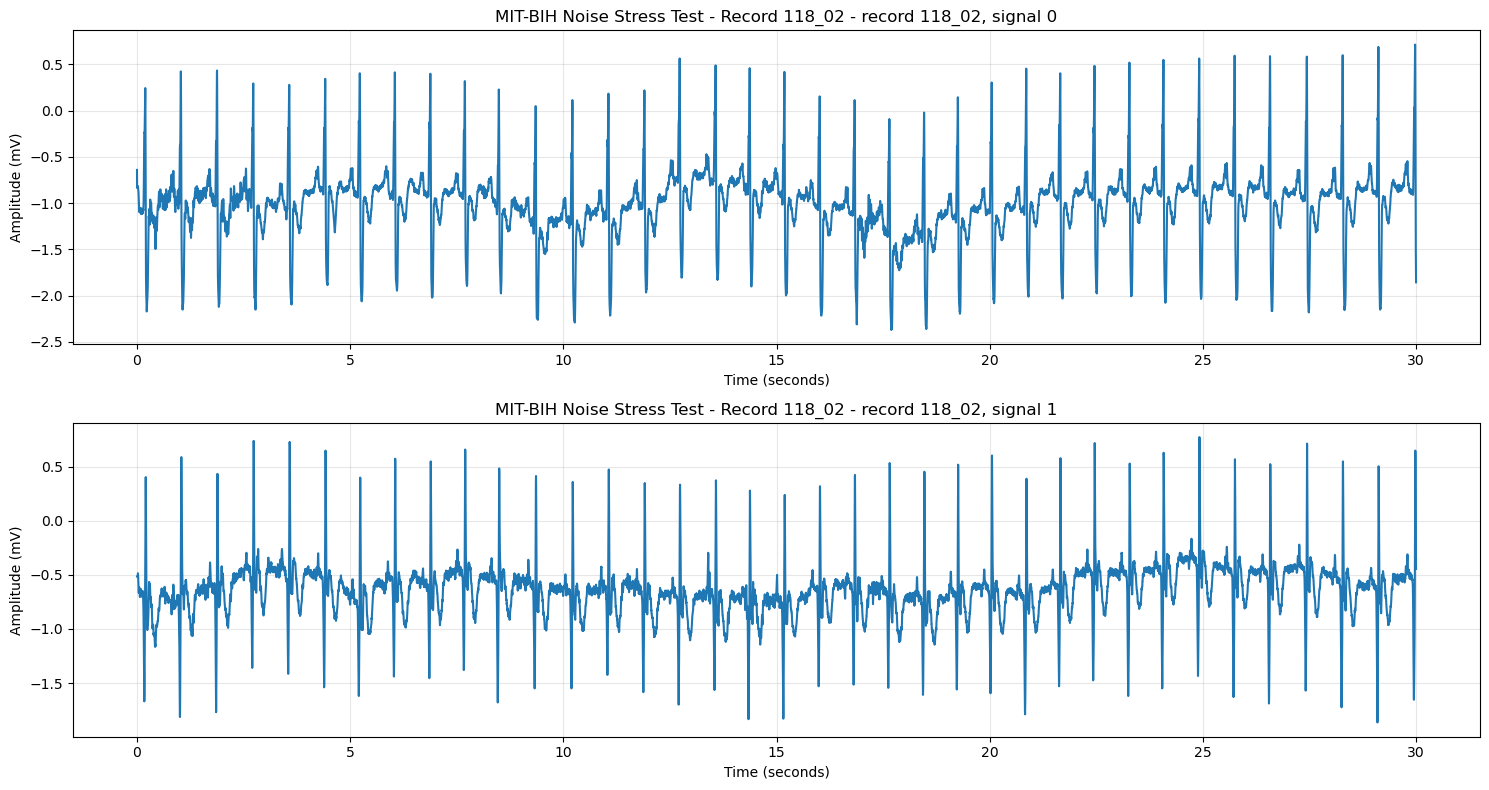


--- SIGNAL QUALITY ASSESSMENT ---

Signal 1 (record 118_02, signal 0):
  Range: -3.845 to 4.465 mV
  Mean: -0.741 mV
  Std Dev: 0.765 mV
  Flat segments: 23.7%
  Signal quality: Poor

Signal 2 (record 118_02, signal 1):
  Range: -4.065 to 3.845 mV
  Mean: -0.579 mV
  Std Dev: 0.477 mV
  Flat segments: 24.4%
  Signal quality: Poor
Extracting C:\Users\Yatin\Downloads\mit-bih-arrhythmia-database-1.0.0.zip...
Extracted to C:\Users\Yatin\AppData\Local\Temp\tmpjpuq5rcf\MIT-BIH Arrhythmia

DATASET: MIT-BIH ARRHYTHMIA
TARGET RECORD: 228

Available records in MIT-BIH Arrhythmia:
Found 71 records: ['100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '111', '112', '113', '114', '115', '116', '117', '118', '119', '121', '122', '123', '124', '200', '201', '202', '203', '205', '207', '208', '209', '210', '212', '213', '214', '215', '217', '219', '220', '221', '222', '223', '228', '230', '231', '232', '233', '234', 'x_108', 'x_109', 'x_111', 'x_112', 'x_113', 'x_114', 'x_115', 'x_1

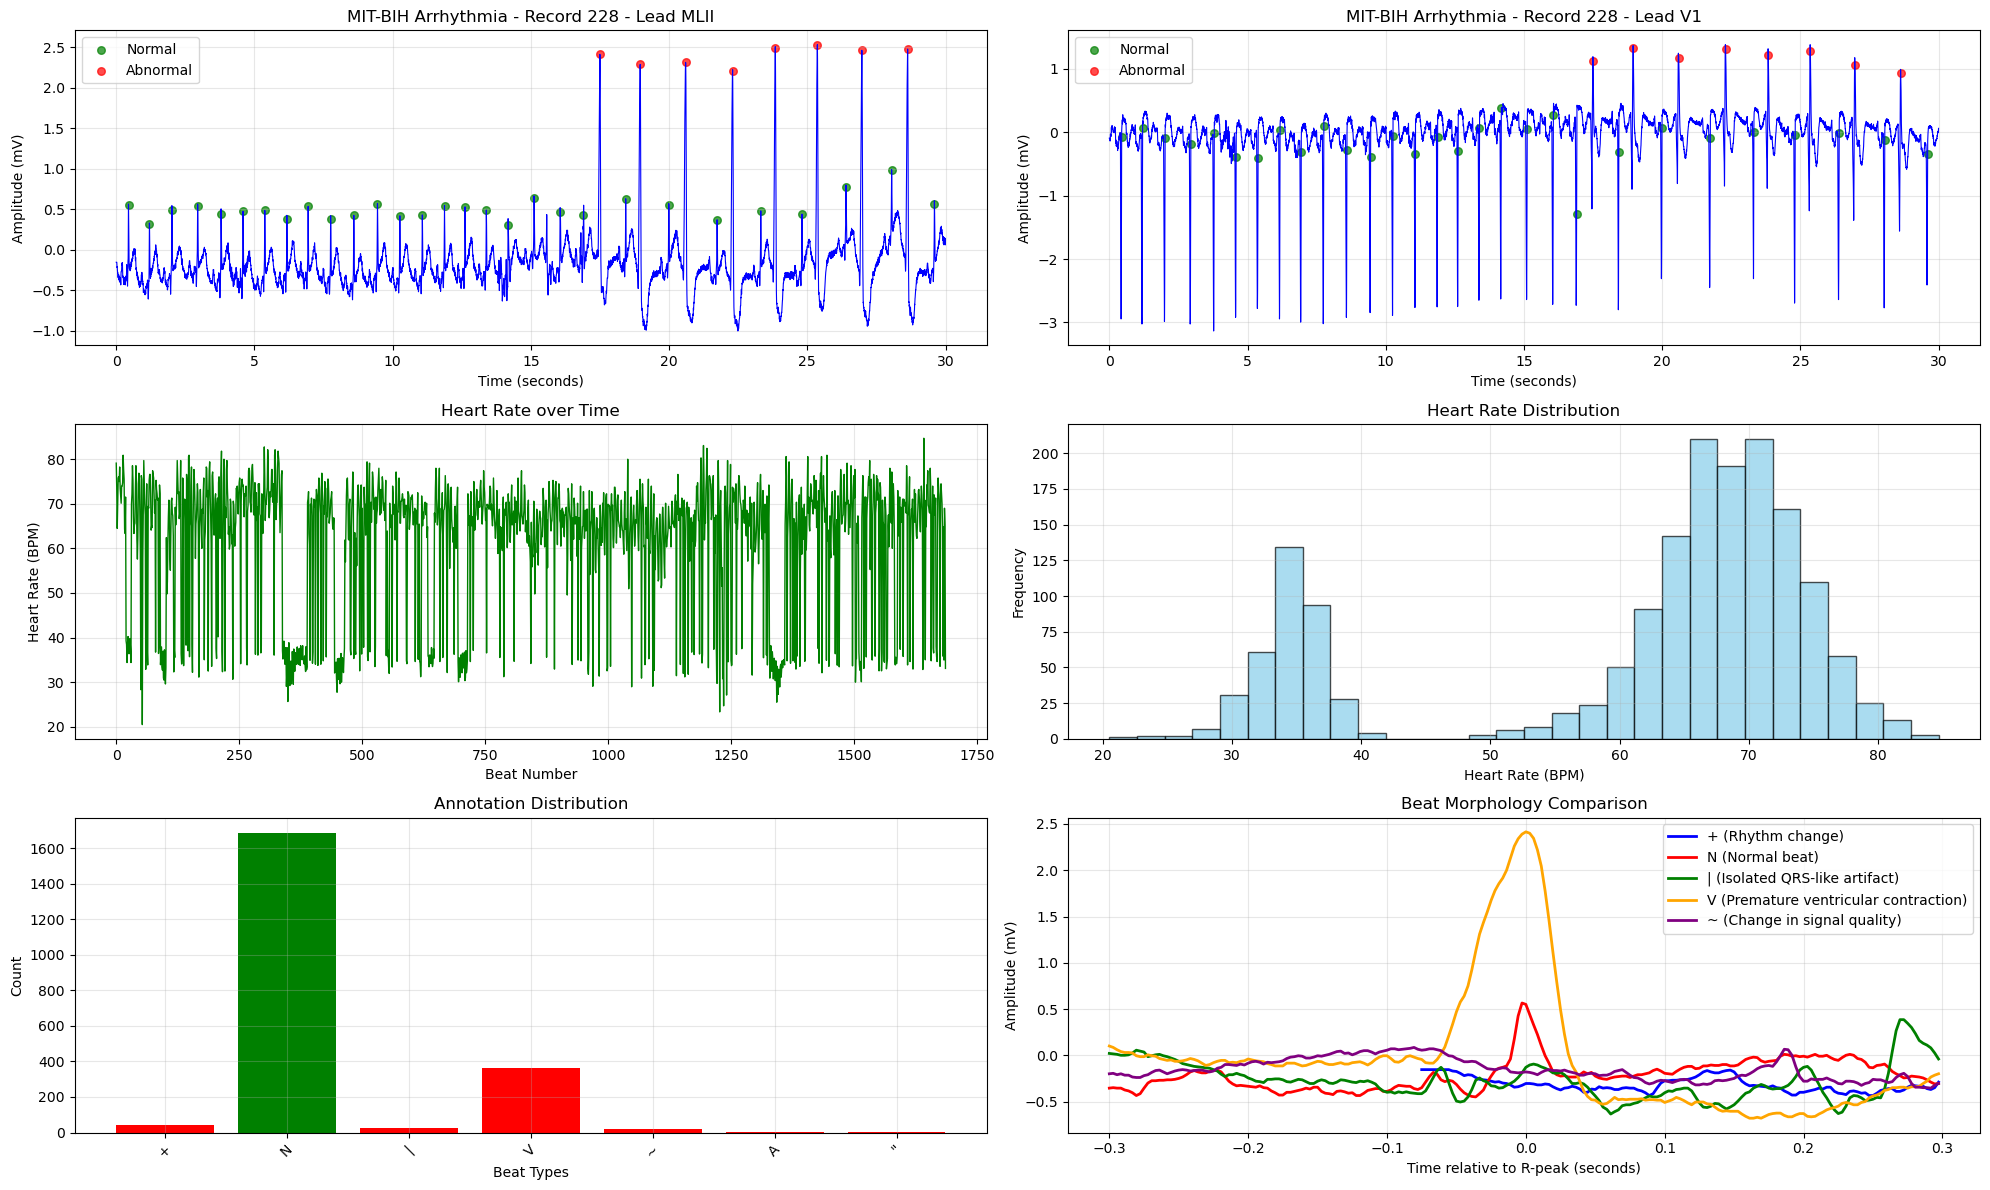


--- SIGNAL QUALITY ASSESSMENT ---

Signal 1 (MLII):
  Range: -2.375 to 2.890 mV
  Mean: -0.138 mV
  Std Dev: 0.346 mV
  Flat segments: 37.3%
  Signal quality: Poor

Signal 2 (V1):
  Range: -3.135 to 3.655 mV
  Mean: -0.001 mV
  Std Dev: 0.499 mV
  Flat segments: 38.5%
  Signal quality: Poor

Cleaning up temporary directory: C:\Users\Yatin\AppData\Local\Temp\tmpjpuq5rcf

ENHANCED ECG DATA ANALYSIS COMPLETE


In [4]:
import zipfile
import os
import numpy as np
import matplotlib.pyplot as plt
import wfdb
import tempfile
import shutil
from pathlib import Path
from collections import Counter
import pandas as pd

# Dataset paths
STRESS_ZIP = r'C:\Users\Yatin\Downloads\mit-bih-noise-stress-test-database-1.0.0.zip'
ARRHYTHMIA_ZIP = r'C:\Users\Yatin\Downloads\mit-bih-arrhythmia-database-1.0.0.zip'

def extract_zip_to_temp(zip_path, temp_dir):
    """Extract zip file to temporary directory"""
    print(f"Extracting {zip_path}...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(temp_dir)
    print(f"Extracted to {temp_dir}")

def list_available_records(temp_dir):
    """List all available records in the dataset"""
    records = set()
    
    for root, dirs, files in os.walk(temp_dir):
        for file in files:
            if file.endswith('.hea') or file.endswith('.dat'):
                record_name = Path(file).stem
                records.add(record_name)
    
    return sorted(list(records))

def find_record_files(temp_dir, record_id):
    """Find all files related to a specific record"""
    record_files = {}
    
    for root, dirs, files in os.walk(temp_dir):
        for file in files:
            if file.startswith(str(record_id)):
                file_path = os.path.join(root, file)
                extension = Path(file).suffix
                record_files[extension] = file_path
                
    return record_files

def get_annotation_descriptions():
    """Get descriptions for MIT-BIH annotation symbols"""
    descriptions = {
        'N': 'Normal beat',
        'L': 'Left bundle branch block beat',
        'R': 'Right bundle branch block beat',
        'A': 'Atrial premature beat',
        'a': 'Aberrated atrial premature beat',
        'J': 'Nodal (junctional) premature beat',
        'S': 'Supraventricular premature beat',
        'V': 'Premature ventricular contraction',
        'F': 'Fusion of ventricular and normal beat',
        '[': 'Start of ventricular flutter/fibrillation',
        '!': 'Ventricular flutter wave',
        ']': 'End of ventricular flutter/fibrillation',
        'e': 'Atrial escape beat',
        'j': 'Nodal (junctional) escape beat',
        'E': 'Ventricular escape beat',
        '/': 'Paced beat',
        'f': 'Fusion of paced and normal beat',
        'x': 'Non-conducted P-wave (blocked APB)',
        'Q': 'Unclassifiable beat',
        '|': 'Isolated QRS-like artifact',
        '~': 'Change in signal quality',
        '+': 'Rhythm change',
        's': 'ST change',
        'T': 'T-wave change',
        '*': 'Systole',
        'D': 'Diastole',
        '"': 'Comment annotation',
        '=': 'Measurement annotation'
    }
    return descriptions

def analyze_heart_rate_variability(annotation, fs):
    """Analyze heart rate variability from R-peak annotations"""
    # Get normal beats only
    normal_beats = []
    for i, symbol in enumerate(annotation.symbol):
        if symbol in ['N', 'L', 'R']:  # Normal and bundle branch beats
            normal_beats.append(annotation.sample[i])
    
    if len(normal_beats) < 2:
        return None
    
    # Calculate RR intervals (in milliseconds)
    rr_intervals = np.diff(normal_beats) / fs * 1000
    
    # Calculate heart rate (beats per minute)
    heart_rates = 60000 / rr_intervals  # 60000 ms = 1 minute
    
    hrv_stats = {
        'mean_rr': np.mean(rr_intervals),
        'std_rr': np.std(rr_intervals),
        'mean_hr': np.mean(heart_rates),
        'std_hr': np.std(heart_rates),
        'min_hr': np.min(heart_rates),
        'max_hr': np.max(heart_rates),
        'rmssd': np.sqrt(np.mean(np.diff(rr_intervals)**2))  # Root mean square of successive differences
    }
    
    return hrv_stats, rr_intervals, heart_rates

def plot_detailed_ecg_analysis(record, annotation, dataset_name, record_id):
    """Create detailed ECG analysis plots"""
    
    # Set up the plotting
    fig = plt.figure(figsize=(20, 12))
    
    # Calculate time axis
    time_axis = np.arange(record.sig_len) / record.fs
    
    # Plot 1: Full ECG signals (first 30 seconds)
    duration_to_plot = min(30, record.sig_len / record.fs)
    samples_to_plot = int(duration_to_plot * record.fs)
    
    # ECG signals
    for i in range(record.n_sig):
        plt.subplot(3, 2, i+1)
        plt.plot(time_axis[:samples_to_plot], record.p_signal[:samples_to_plot, i], 'b-', linewidth=0.8)
        
        # Add annotation markers
        ann_in_range = []
        ann_times = []
        for j, sample in enumerate(annotation.sample):
            if sample < samples_to_plot:
                ann_in_range.append(j)
                ann_times.append(sample / record.fs)
        
        if ann_in_range:
            ann_values = [record.p_signal[annotation.sample[j], i] for j in ann_in_range]
            ann_symbols = [annotation.symbol[j] for j in ann_in_range]
            
            # Plot different types of beats with different colors
            normal_indices = [k for k, sym in enumerate(ann_symbols) if sym in ['N', 'L', 'R']]
            abnormal_indices = [k for k, sym in enumerate(ann_symbols) if sym not in ['N', 'L', 'R', '+', '~', '|']]
            
            if normal_indices:
                normal_times = [ann_times[k] for k in normal_indices]
                normal_values = [ann_values[k] for k in normal_indices]
                plt.scatter(normal_times, normal_values, c='green', s=30, alpha=0.7, label='Normal')
            
            if abnormal_indices:
                abnormal_times = [ann_times[k] for k in abnormal_indices]
                abnormal_values = [ann_values[k] for k in abnormal_indices]
                plt.scatter(abnormal_times, abnormal_values, c='red', s=30, alpha=0.7, label='Abnormal')
        
        plt.title(f'{dataset_name} - Record {record_id} - Lead {record.sig_name[i]}')
        plt.xlabel('Time (seconds)')
        plt.ylabel(f'Amplitude ({record.units[i]})')
        plt.grid(True, alpha=0.3)
        plt.legend()
    
    # Plot 3: Heart Rate Variability (if we have annotations)
    hrv_data = analyze_heart_rate_variability(annotation, record.fs)
    if hrv_data:
        hrv_stats, rr_intervals, heart_rates = hrv_data
        
        plt.subplot(3, 2, 3)
        plt.plot(heart_rates, 'g-', linewidth=1)
        plt.title('Heart Rate over Time')
        plt.xlabel('Beat Number')
        plt.ylabel('Heart Rate (BPM)')
        plt.grid(True, alpha=0.3)
        
        plt.subplot(3, 2, 4)
        plt.hist(heart_rates, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        plt.title('Heart Rate Distribution')
        plt.xlabel('Heart Rate (BPM)')
        plt.ylabel('Frequency')
        plt.grid(True, alpha=0.3)
    
    # Plot 5: Annotation distribution
    plt.subplot(3, 2, 5)
    annotation_counts = Counter(annotation.symbol)
    descriptions = get_annotation_descriptions()
    
    # Prepare data for plotting
    symbols = list(annotation_counts.keys())
    counts = list(annotation_counts.values())
    labels = [f"{sym} ({descriptions.get(sym, 'Unknown')})" for sym in symbols]
    
    plt.bar(range(len(symbols)), counts, color=['red' if sym not in ['N', 'L', 'R'] else 'green' for sym in symbols])
    plt.title('Annotation Distribution')
    plt.xlabel('Beat Types')
    plt.ylabel('Count')
    plt.xticks(range(len(symbols)), symbols, rotation=45)
    plt.grid(True, alpha=0.3)
    
    # Plot 6: Detailed view of specific beats
    plt.subplot(3, 2, 6)
    # Find some different beat types for detailed view
    beat_samples = {}
    for i, symbol in enumerate(annotation.symbol[:100]):  # Look at first 100 annotations
        if symbol not in beat_samples and len(beat_samples) < 5:
            beat_samples[symbol] = annotation.sample[i]
    
    colors = ['blue', 'red', 'green', 'orange', 'purple']
    for idx, (symbol, sample) in enumerate(beat_samples.items()):
        start_sample = max(0, sample - int(0.3 * record.fs))
        end_sample = min(record.sig_len, sample + int(0.3 * record.fs))
        time_segment = np.arange(start_sample, end_sample) / record.fs
        signal_segment = record.p_signal[start_sample:end_sample, 0]
        
        plt.plot(time_segment - sample/record.fs, signal_segment, 
                color=colors[idx % len(colors)], linewidth=2, 
                label=f'{symbol} ({descriptions.get(symbol, "Unknown")})')
    
    plt.title('Beat Morphology Comparison')
    plt.xlabel('Time relative to R-peak (seconds)')
    plt.ylabel(f'Amplitude ({record.units[0]})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def load_and_display_ecg_enhanced(dataset_name, zip_path, record_id, temp_base_dir):
    """Enhanced ECG loading and analysis"""
    
    temp_dir = os.path.join(temp_base_dir, dataset_name)
    os.makedirs(temp_dir, exist_ok=True)
    
    try:
        extract_zip_to_temp(zip_path, temp_dir)
        available_records = list_available_records(temp_dir)
        
        print(f"\n{'='*80}")
        print(f"DATASET: {dataset_name.upper()}")
        print(f"TARGET RECORD: {record_id}")
        print(f"{'='*80}")
        
        print(f"\nAvailable records in {dataset_name}:")
        print(f"Found {len(available_records)} records: {available_records}")
        
        record_files = find_record_files(temp_dir, record_id)
        
        if not record_files:
            print(f"\nRecord {record_id} not found in {dataset_name}!")
            if available_records:
                record_id = available_records[0]
                print(f"Using first available record: {record_id}")
                record_files = find_record_files(temp_dir, record_id)
            else:
                print("No records found in this dataset!")
                return
        
        print(f"\nFiles for record {record_id}:")
        for ext, path in record_files.items():
            print(f"  {ext}: {os.path.basename(path)}")
        
        # Find record directory
        record_dir = None
        for root, dirs, files in os.walk(temp_dir):
            if any(file.startswith(str(record_id)) for file in files):
                record_dir = root
                break
        
        if record_dir is None:
            print(f"Could not find record {record_id} in the dataset")
            return
        
        # Load the record
        record_path = os.path.join(record_dir, str(record_id))
        record = wfdb.rdrecord(record_path)
        
        print(f"\n--- COMPREHENSIVE RECORD INFORMATION ---")
        print(f"Record Name: {record.record_name}")
        print(f"Sampling Frequency: {record.fs} Hz")
        print(f"Number of Samples: {record.sig_len:,}")
        print(f"Duration: {record.sig_len / record.fs:.2f} seconds ({(record.sig_len / record.fs)/60:.1f} minutes)")
        print(f"Number of Signals: {record.n_sig}")
        print(f"Signal Names: {record.sig_name}")
        print(f"Units: {record.units}")
        print(f"ADC Gain: {record.adc_gain}")
        print(f"Baseline: {record.baseline}")
        print(f"Comments: {record.comments}")
        
        # Load annotations
        try:
            annotation = wfdb.rdann(record_path, 'atr')
            
            print(f"\n--- DETAILED ANNOTATION ANALYSIS ---")
            print(f"Total annotations: {len(annotation.sample):,}")
            
            # Analyze annotation types
            annotation_counts = Counter(annotation.symbol)
            descriptions = get_annotation_descriptions()
            
            print(f"\nAnnotation breakdown:")
            for symbol, count in annotation_counts.most_common():
                description = descriptions.get(symbol, 'Unknown')
                percentage = (count / len(annotation.symbol)) * 100
                print(f"  {symbol}: {count:,} ({percentage:.1f}%) - {description}")
            
            # Heart Rate Variability Analysis
            hrv_data = analyze_heart_rate_variability(annotation, record.fs)
            if hrv_data:
                hrv_stats, rr_intervals, heart_rates = hrv_data
                
                print(f"\n--- HEART RATE VARIABILITY ANALYSIS ---")
                print(f"Mean RR Interval: {hrv_stats['mean_rr']:.2f} ms")
                print(f"RR Interval Std Dev: {hrv_stats['std_rr']:.2f} ms")
                print(f"Mean Heart Rate: {hrv_stats['mean_hr']:.1f} BPM")
                print(f"Heart Rate Range: {hrv_stats['min_hr']:.1f} - {hrv_stats['max_hr']:.1f} BPM")
                print(f"RMSSD: {hrv_stats['rmssd']:.2f} ms")
            
            # Clinical interpretation
            print(f"\n--- CLINICAL INTERPRETATION ---")
            normal_beats = annotation_counts.get('N', 0) + annotation_counts.get('L', 0) + annotation_counts.get('R', 0)
            abnormal_beats = len(annotation.symbol) - normal_beats - annotation_counts.get('+', 0) - annotation_counts.get('~', 0) - annotation_counts.get('|', 0)
            
            if abnormal_beats > 0:
                abnormal_percentage = (abnormal_beats / len(annotation.symbol)) * 100
                print(f"Abnormal beats detected: {abnormal_beats} ({abnormal_percentage:.1f}%)")
                if annotation_counts.get('V', 0) > 0:
                    print(f"- Premature Ventricular Contractions (PVCs): {annotation_counts['V']}")
                if annotation_counts.get('A', 0) > 0:
                    print(f"- Atrial Premature Beats: {annotation_counts['A']}")
            else:
                print("Predominantly normal rhythm detected")
            
            # Create detailed plots
            plot_detailed_ecg_analysis(record, annotation, dataset_name, record_id)
            
        except Exception as e:
            print(f"\nError loading annotations: {e}")
            # Still plot the ECG without annotations
            plt.figure(figsize=(15, 8))
            duration_to_plot = min(30, record.sig_len / record.fs)
            samples_to_plot = int(duration_to_plot * record.fs)
            time_axis = np.arange(samples_to_plot) / record.fs
            
            for i in range(record.n_sig):
                plt.subplot(record.n_sig, 1, i+1)
                plt.plot(time_axis, record.p_signal[:samples_to_plot, i])
                plt.title(f'{dataset_name} - Record {record_id} - {record.sig_name[i]}')
                plt.xlabel('Time (seconds)')
                plt.ylabel(f'Amplitude ({record.units[i]})')
                plt.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
        
        # Signal quality assessment
        print(f"\n--- SIGNAL QUALITY ASSESSMENT ---")
        for i in range(record.n_sig):
            signal_data = record.p_signal[:, i]
            
            # Check for saturation
            max_val = np.max(signal_data)
            min_val = np.min(signal_data)
            saturation_check = (max_val > 0.95 * np.max(signal_data)) or (min_val < 0.95 * np.min(signal_data))
            
            # Check for flat segments
            diff_signal = np.diff(signal_data)
            flat_segments = np.sum(np.abs(diff_signal) < 0.01) / len(diff_signal) * 100
            
            print(f"\nSignal {i+1} ({record.sig_name[i]}):")
            print(f"  Range: {min_val:.3f} to {max_val:.3f} {record.units[i]}")
            print(f"  Mean: {np.mean(signal_data):.3f} {record.units[i]}")
            print(f"  Std Dev: {np.std(signal_data):.3f} {record.units[i]}")
            print(f"  Flat segments: {flat_segments:.1f}%")
            print(f"  Signal quality: {'Good' if flat_segments < 5 else 'Poor'}")
        
    except Exception as e:
        print(f"Error processing {dataset_name}: {e}")

def main():
    """Main function with enhanced analysis"""
    
    if not os.path.exists(STRESS_ZIP):
        print(f"Stress dataset not found at: {STRESS_ZIP}")
        return
    
    if not os.path.exists(ARRHYTHMIA_ZIP):
        print(f"Arrhythmia dataset not found at: {ARRHYTHMIA_ZIP}")
        return
    
    temp_base_dir = tempfile.mkdtemp()
    print(f"Using temporary directory: {temp_base_dir}")
    
    try:
        # Process both datasets with enhanced analysis
        load_and_display_ecg_enhanced("MIT-BIH Noise Stress Test", STRESS_ZIP, 101, temp_base_dir)
        load_and_display_ecg_enhanced("MIT-BIH Arrhythmia", ARRHYTHMIA_ZIP, 228, temp_base_dir)
        
    finally:
        print(f"\nCleaning up temporary directory: {temp_base_dir}")
        shutil.rmtree(temp_base_dir)
        
    print("\n" + "="*80)
    print("ENHANCED ECG DATA ANALYSIS COMPLETE")
    print("="*80)

if __name__ == "__main__":
    main()